In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Import the usual suspects

## Building and solving a coupling matrix

We want to solve something of the form 

$i \frac{\partial \phi_n}{\partial z} = C_{m, m+a_1} e^{iA((m + a_1) /2)\cdot a_1} \phi_{m+a_1} +  C_{m, m+a_2} e^{iA((m + a_2) /2)\cdot a_2} \phi_{m+a_2}+  C_{m, m+a_3} e^{iA((m + a_3) /2)\cdot a_3} \phi_{m+a_3} + D_n \phi_n $

The first three terms are the effects due to coupling with neighbours, while the fourth term is the on-site change due to the presence of twist.

First let's define a function that handles the effects of twist

Turning to: Ma X et al. 2011 Angular-momentum coupled optical waves in chirally-coupled-core fibers Opt. Expr. 19

They find: $ \beta_{hel} \approx \beta_{straight} \sqrt{1+\alpha^2 R^2}$ 
if $(\alpha R)^2$ is small we can approximate: $\beta_{hel} \approx \beta_{straight} + \frac{\beta_{straight}}{2}(\alpha R)^2$


In [2]:
def twisted_beta(beta_straight, twist_rate, radial_dist):
    beta_hel = beta_straight*np.sqrt(1+ twist_rate**2 * radial_dist**2)
    # print('Difference due to twist: {:.2f}'.format(beta_hel-beta_straight))
    return beta_hel

vec_twist_beta = np.vectorize(twisted_beta)

In [3]:
def build_honeycomb(n,m, pitch):
    a_1 = np.array([3*pitch/2, np.sqrt(3)*pitch/2])
    a_2 = np.array([3*pitch/2, -np.sqrt(3)*pitch/2])

    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list_shifted = coord_list + np.array([-pitch, 0])
    coord_list = np.array(coord_list)
    # print(coord_list_shifted)


    full_coord_list = np.concatenate((coord_list, coord_list_shifted), axis=0)
    centered_coord_list = full_coord_list - (n*a_1 + m*a_2)/2 + np.array([2*pitch,0])

    return centered_coord_list

4000


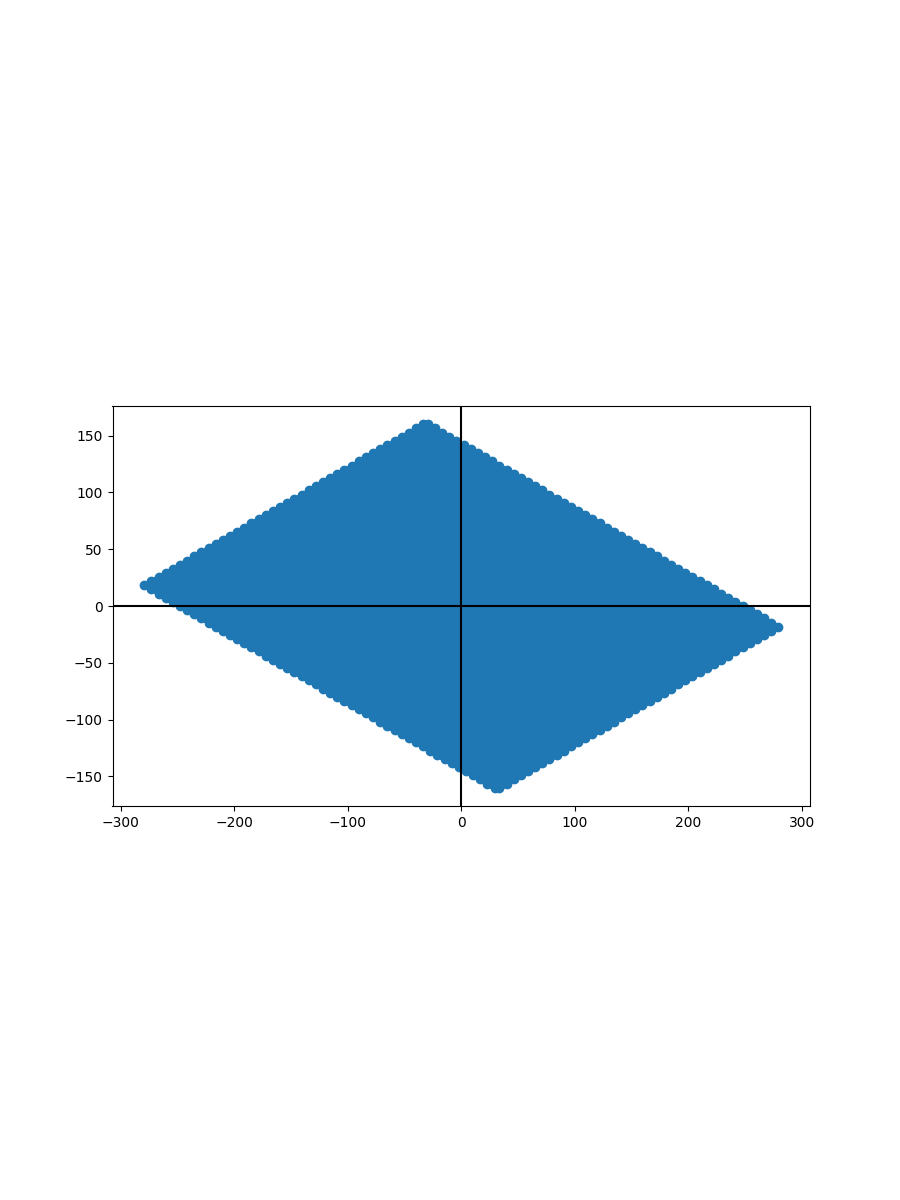

In [6]:
PITCH = 4.2
b_10_list = build_honeycomb(40,50, PITCH)

fig_lattice_plot = plt.figure(figsize=(9,12))
ax_lattice_plot = fig_lattice_plot.add_subplot(111)
ax_lattice_plot.axhline(0, color='black')
ax_lattice_plot.axvline(0, color='black')
ax_lattice_plot.scatter(b_10_list[:,0], b_10_list[:,1])
ax_lattice_plot.set_aspect('equal')
print(len(b_10_list))

plt.show()

If we want a deformed lattice we can delete cores using the code below 

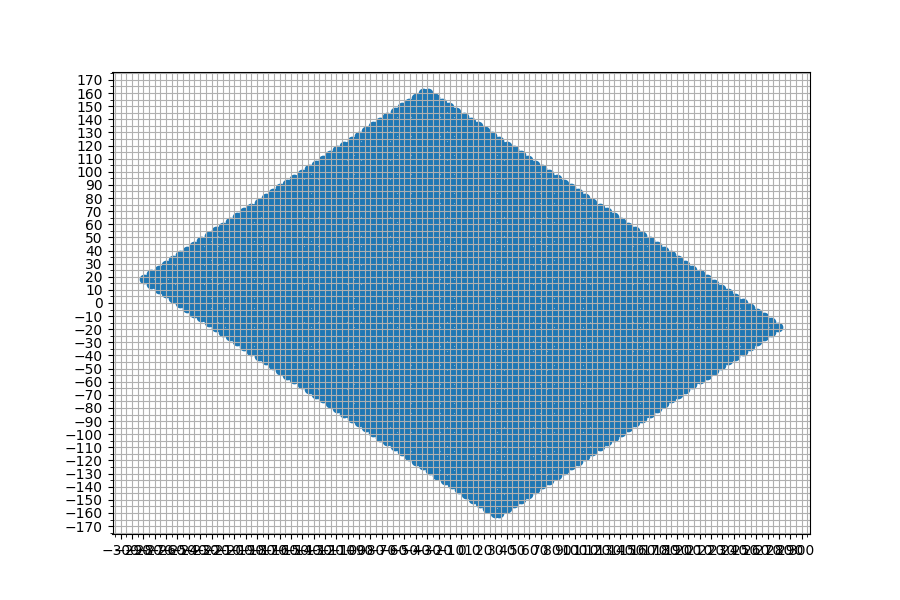

In [7]:
def onclick(event):
    pos.append([event.xdata,event.ydata])

pos = []

fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(111)

ax1.scatter(b_10_list[:,0], b_10_list[:,1], cmap='Reds')
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig1.canvas.mpl_connect('button_press_event', onclick)
plt.show()


In [8]:

pos = np.array(pos)
points_to_keep = np.where(cdist(b_10_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.invert(np.any(points_to_keep, axis=1))
deformed_lattice= b_10_list[index_to_keep]
# [print(type(i)) for i in pos]


4000


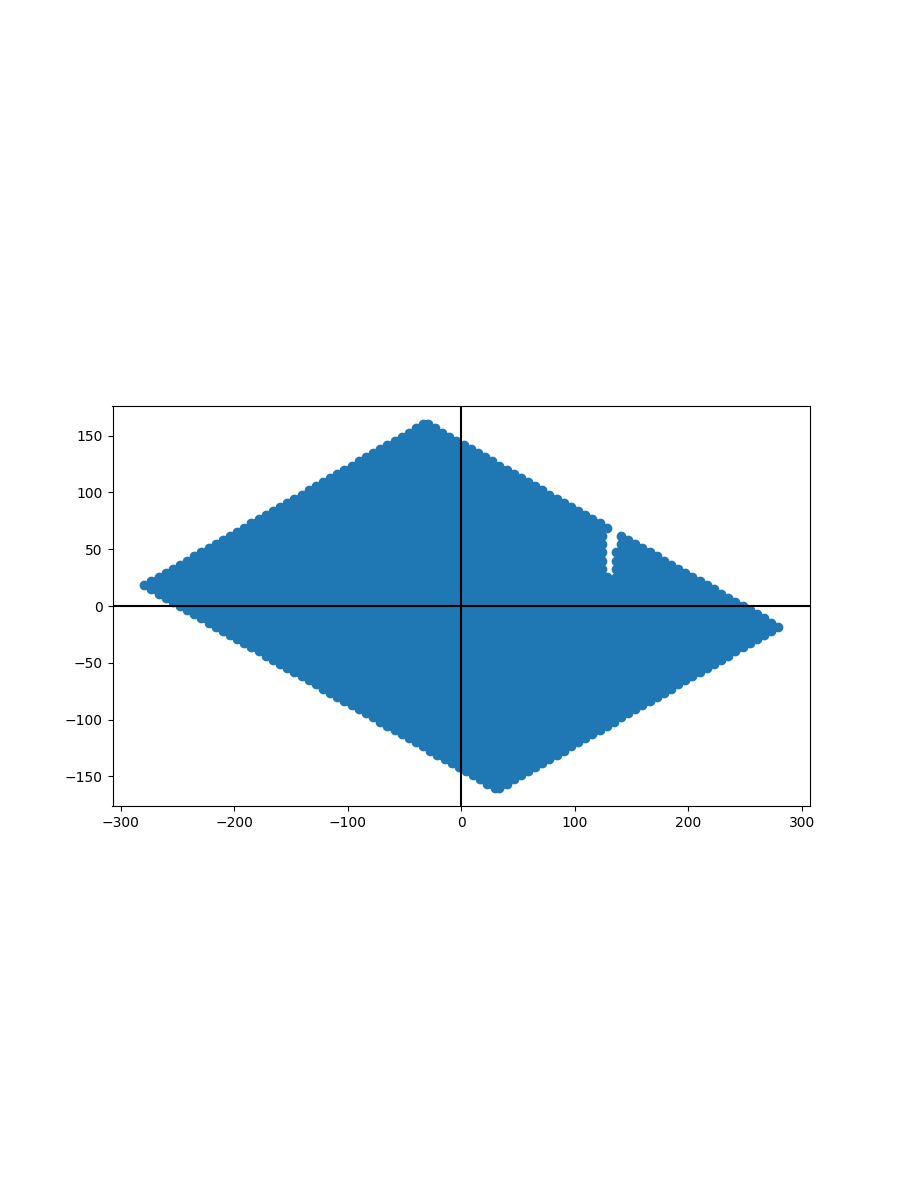

In [9]:


fig_deformed_lattice_plot = plt.figure(figsize=(9,12))
ax_deformed_lattice_plot = fig_deformed_lattice_plot.add_subplot(111)
ax_deformed_lattice_plot.axhline(0, color='black')
ax_deformed_lattice_plot.axvline(0, color='black')
ax_deformed_lattice_plot.scatter(deformed_lattice[:,0], deformed_lattice[:,1])
ax_deformed_lattice_plot.set_aspect('equal')
print(len(b_10_list))

plt.show()

Build_onsite adds the difference in propagation constant that occurs due to the twisting of the fibre

In [12]:

def build_onsite(beta_straight, twist, coord_pairs):
    distance_to_each_core = np.array([round(np.sqrt(i**2 + j**2),4) for i,j in coord_pairs])*1e-6

    twist_for_each_core = vec_twist_beta(beta_straight, twist, distance_to_each_core) - beta_straight
    onsite_matrix = np.diag(twist_for_each_core)

    return onsite_matrix

Next we build up the vector potential $\mathbf{A}(\mathbf{r})$ which acts as the coriolis force  

In [11]:
def vec_potential(x,y, twist_rate, beta):
    vec_A = twist_rate*beta*np.array([y,-x])
    return vec_A


ABC_sections draws three equal sections over the lattice which is used for the real space chern number calculation

In [13]:

def ABC_sections(x_size):
    """
    Draw three equal sized polygons over the lattice, labelled counterclockwise.
    Input only the width of the total composite rectangle made from the three polygons.
    Returns the patches shape objects. 
    """
    xyA = np.array([[0,0], [x_size, -x_size*0.5], [x_size, x_size], [0, x_size]])
    xyC = np.array([[0,0],[x_size,-x_size*0.5],[x_size, -x_size*0.875], [-x_size,-0.875*x_size],[-x_size,-x_size*0.5]])
    xyB = np.array([[0,0], [-x_size, -x_size*0.5], [-x_size, x_size], [0, x_size]])
    shape_A = patches.Polygon(xyA,alpha=0.1, label='A')
    shape_B = patches.Polygon(xyB,fc='green', alpha=0.1, label='B')
    shape_C = patches.Polygon(xyC,fc='red', alpha=0.1, label='C')

    return shape_A, shape_B, shape_C

In [14]:
def index_in_sections(pair_list, sample_width):
    """
    Input a list of points that correspond to a lattice geometry. Pair list in the form: [[x1,y1],[x2,y2],[x3,y3]]
    Sample width is the width of the rectangle used to split the lattice into three different sections.
    The returned lists are the indices of points within each of the sections A, B, C defined in ABC sections. 
    """

    A_shape, B_shape, C_shape, = ABC_sections(sample_width)
    
    fig_for_index = plt.figure(figsize=(9,6))
    ax_for_index = fig_for_index.add_subplot(111)

    ax_for_index.scatter(pair_list[:,0], pair_list[:,1])

    ax_for_index.add_patch(A_shape)
    ax_for_index.add_patch(B_shape)
    ax_for_index.add_patch(C_shape)
    
    # I have to write pair list as (ax_for_index.transData.transform(pair_list)
    #  to get the data in the right form for contains points to work)
    Acont = A_shape.contains_points(ax_for_index.transData.transform(pair_list)).nonzero()[0]
    Bcont = B_shape.contains_points(ax_for_index.transData.transform(pair_list)).nonzero()[0]
    Ccont = C_shape.contains_points(ax_for_index.transData.transform(pair_list)).nonzero()[0]
    # plt.show()

    return Acont, Bcont, Ccont

Building the coupling matrix and finding the eigenvalues for our twisted fibre system

In [15]:
def find_eigvalues(pair_list, pitch, coupling_c, beta_straight, twist, with_onsite=True):
    """ 
    Take in the lattice points and find nearest neighbours, then add a coupling c between them.
    Add a phase term created using the vector potential 
    """
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=complex)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    for i in nearest_neighbour_array:
        mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
        a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
        # print(mid_point)
        vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        coupling_matrix[i[0],i[1]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist))

        a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        coupling_matrix[i[1],i[0]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist_rev))
    if with_onsite is True:
        onsite_matrix = build_onsite(beta_straight, twist, pair_list)
        full_C = coupling_matrix + onsite_matrix
    else: 
        full_C = coupling_matrix
    # print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))
    beta_super, eigvecs = np.linalg.eigh(full_C)

    return beta_super,eigvecs


Building the coupling matrix and finding the eigenvalues/vectors for the haldane model

In [17]:
def find_eigvalues_haldane(pair_list, pitch, coupling_c1, coupling_c2, M):
    """  
        pair_lisst is the lattice coord list, pitch is the distance between nearest neighbours,
        coupling_c1 is nn coupling, coupling_c2 is nnn coupling, M is the onsite term.

        First I build a tree and find all nearest and next-nearest neighbours, splitting them 
        into separate lists to build up the coupling matrix with. 

        The angle between points (when nnn) is calculated to determine the sign of the imaginary 
        coupling. This gives the points a positive imaginary coupling if they're travelling 
        anticlockwise and negative if clockwise.
    """
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=np.complex128)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=50)
    next_and_neighbour_array = honeycomb_point_tree.query_pairs(np.sqrt(3)*(pitch+0.001), output_type = 'ndarray')
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.0001, output_type = 'ndarray')
    
    # easiest to create a list of tuples to remove any nearest neighbours from all pairs
    #  within next-nearest neighbour distance
    tup_all_list = [(i[0],i[1]) for i in next_and_neighbour_array]
    tup_nn_list = [(i[0],i[1]) for i in nearest_neighbour_array]
    tup_next_n_list = [i for i in tup_all_list if i not in tup_nn_list]

    for n in nearest_neighbour_array:
        coupling_matrix[n[0],n[1]] = coupling_c1
        coupling_matrix[n[1],n[0]] = coupling_c1

    # Logic to build up clockwise dependent phase in next-nearest neighbour coupling
    for i in tup_next_n_list:
        if i[0] >= len(pair_list)//2:
            a_or_b = -1
        else:
            a_or_b = 1
        # print(a_or_b)
        vec_between_points = pair_list[i[1]] - pair_list[i[0]]
        if vec_between_points[0] == 0:
            if vec_between_points[1] > 0:
                coupling_i = 1.0j*coupling_c2  
            elif vec_between_points[1] < 0: 
                coupling_i = -1.0j*coupling_c2 
        else:
            angle_between_points = np.arctan(vec_between_points[1]/vec_between_points[0])
            if angle_between_points > 0 and angle_between_points < 4*np.pi/10:
                coupling_i = -1.0j*coupling_c2 
            elif angle_between_points < 0 and angle_between_points > -4*np.pi/10: 
                coupling_i = 1.0j*coupling_c2 

        coupling_matrix[i[0],i[1]] = a_or_b*coupling_i
        coupling_matrix[i[1],i[0]] = -a_or_b*coupling_i       

    onsite = np.eye(len(pair_list[:,0]),dtype=np.complex128)*M 
    full_matrix = coupling_matrix + onsite
    # display(pd.DataFrame(full_matrix))
    beta_super, eigvecs = np.linalg.eigh(full_matrix)

    return beta_super,eigvecs

In [19]:
# Plotting betas
def plot_betas(beta_vals, point_label, xrange=[]):
    """
        Function to nicely plot the propagation constants for easy
        band determination.

        beta_vals is the list of prop consts. 

        point label can be a list of str or a str labelling the data
        xrange can be set to only plot a slice of prop consts. 
    """

    fig1  = plt.figure(figsize=(12,12))   
    ax1 = fig1.add_subplot(111)

    if type(beta_vals) == list:
        for i,vals in enumerate(beta_vals):
            ax1.scatter(np.arange(len(vals)), vals, label=point_label[i])

    else: 
        ax1.scatter(np.arange(len(beta_vals)), beta_vals-np.mean(beta_vals), label=point_label)

    ax1.grid(axis='x', which='both')
    ax1.set_ylabel(r'$ \beta/C$')
    ax1.set_xlabel('Mode Index')
    if len(xrange) == 2:
        ax1.set_xlim(xrange[0],xrange[1])
    plt.legend();
    return 


In [20]:
# For nice plotting of eigenvectors 
def plot_coloured_chain(intensities, circ_size, circ_locations, label):
    """
        Function for visualising the eigenvectors as fibre core excitations.
        Plots a lattice of circles with color corresponding to intensity.    
    """
    fig_chain = plt.figure(figsize=(15,10))
    ax_chain = fig_chain.add_subplot(111)
    intensities = intensities/np.sum(intensities)
    circ_list = []
    norm = colors.Normalize(vmin=min(np.real(intensities)), vmax=max(np.real(intensities)))
    cmap = plt.cm.get_cmap('Reds')
    cmap(norm(np.real(intensities)))

    for j in range(len(intensities)):
        circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                            color=cmap(norm(np.real(intensities[j]))),ec='black')) 

   
    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)
    plt.title('Mode no. {:d}'.format(label), loc='left')
    plt.axis('scaled')
    plt.show()     
    return 

Calculate local Chern number

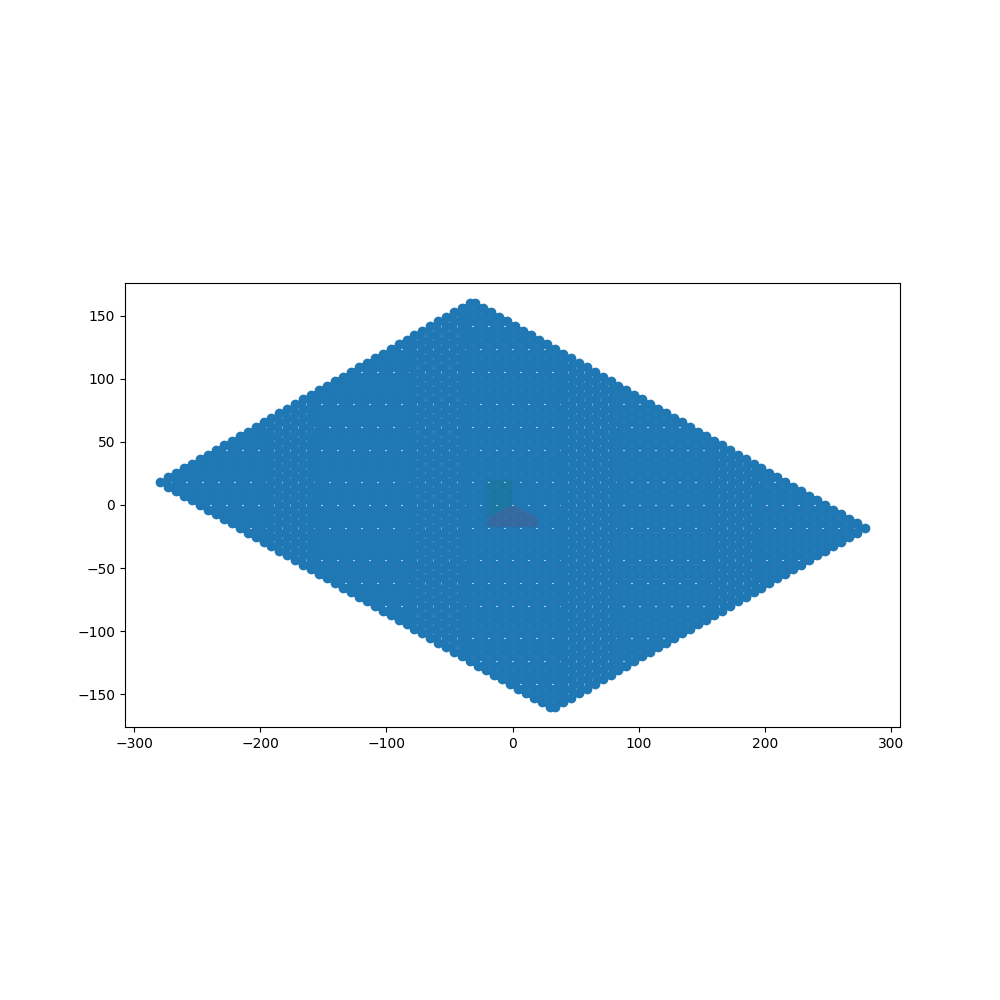

In [22]:
# Plotting lattice and A,B,C sections to visually confirm what is happening

fig_lattice = plt.figure(figsize=(10,10))
ax_lattice = fig_lattice.add_subplot(111)

ax_lattice.scatter(b_10_list[:,0], b_10_list[:,1])
a_s, b_s, c_s = ABC_sections(20)
ax_lattice.add_patch(a_s)
ax_lattice.add_patch(b_s)
ax_lattice.add_patch(c_s)
ax_lattice.set_aspect('equal')
plt.show()

https://www.nature.com/articles/s41567-017-0024-5

Using the method from this paper we can split up the lattice into three distinct sections and then project them onto a given band. Following a loop a -> b -> c, we evaluate the overlap of all band eigenvalues with points in these sections 

In [23]:
# First I build up the projector matrix for the desired band
# defining this func to check if matrix is symmetric
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def real_space_chern_calc(beta_vals, beta_vecs, band_start, section_size):
    """
        Function to calculate real space chern numbers using method outlined in mitchel et al. 2018
    """
    ## individual_matrix_list = np.zeros((len(beta_vecs), len(beta_vecs), len(band_range)), dtype=np.complex128)
    ## for point in band_range:
    #    # individual_matrix_list[:,:,point] = np.outer(beta_vecs[point],np.conjugate(beta_vecs[point]))
    ## projector_matrix_orig = np.sum(individual_matrix_list, axis=2) 
      
    # Code above has been replaced with einsum, still building a list of outer products
    # then summing that list over a range of eigenvalues in a given band
    projector_matrix = np.einsum('in,jn-> ij', beta_vecs[:,band_start:], np.conjugate(beta_vecs[:,band_start:]))

    # Next I collect points in A,B,C sections
    a_indices, b_indices, c_indices = index_in_sections(b_10_list, section_size)

    # quick sanity check on symmetry of projector
    print(check_symmetric(projector_matrix))

    # Finally I find the overlap of the projector with all combinations of points 
    all_h_vals = np.zeros((len(a_indices), len(b_indices), len(c_indices)), dtype=np.complex128)
    # for each point in the A,B,C sections the projectors are found
    #  c->b->a permutation of projection values are subtracted from a->b->c. 
    # This difference is connected to the system's chern number 
    for na,a_index in enumerate(a_indices):
        for nb,b_index in enumerate(b_indices):
            for nc,c_index in enumerate(c_indices):
                all_h_vals[na, nb, nc] = 12*np.pi*1.0j*(projector_matrix[a_index,b_index]*projector_matrix[b_index, c_index]*projector_matrix[c_index,a_index] - 
                                                        projector_matrix[a_index,c_index]*projector_matrix[c_index, b_index]*projector_matrix[b_index,a_index])
                                                        #h_i_j_k(a_index, b_index, c_index, projector_matrix)                       
    # sum over total permutation differences to get chern no. 
    chern_no = np.sum(all_h_vals)
    print(chern_no)
    return chern_no


Now I check the method works by verifying the chern number of the Haldane model

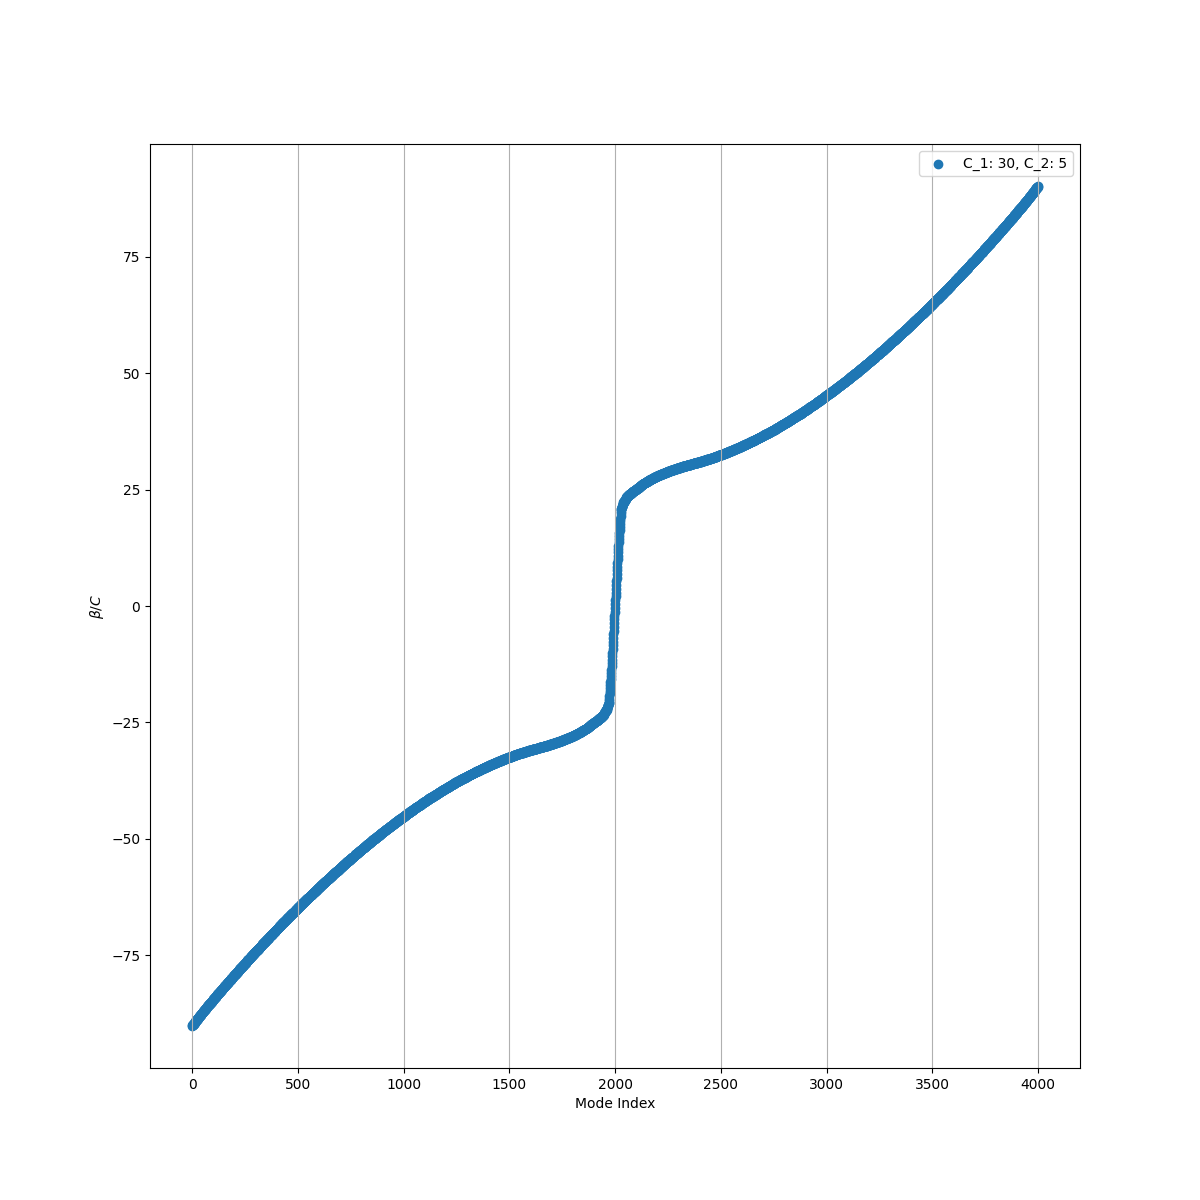

In [24]:
# Plotting the propagation constants to find band edge 
haldane_vals, haldane_vecs = find_eigvalues_haldane(b_10_list, 4.2, 30, 5, 0.0)
plot_betas(haldane_vals, 'C_1: 30, C_2: 5')

False
(0.9656612365045699+5.0711908294266e-19j)


(0.9656612365045699+5.0711908294266e-19j)

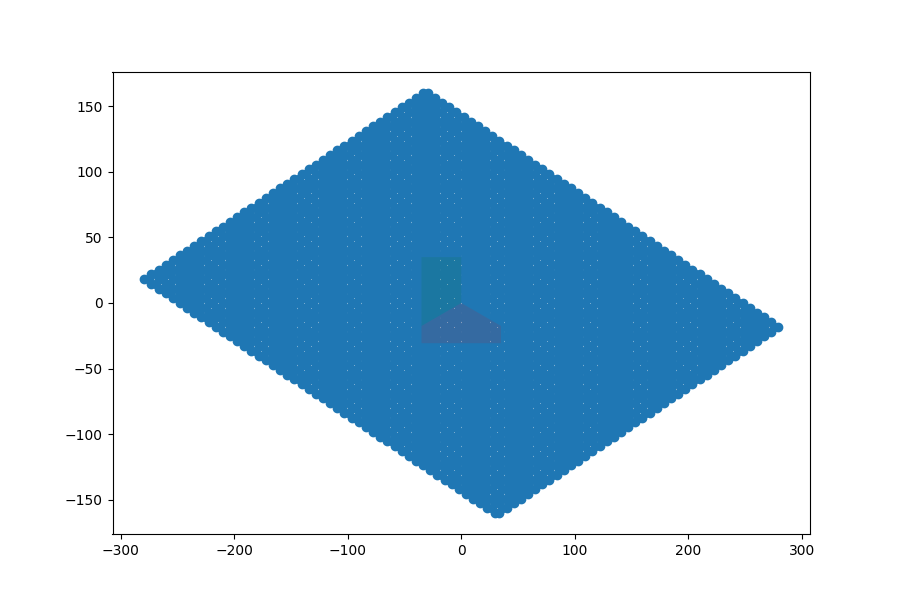

In [25]:
# Calculating chern number 
real_space_chern_calc(haldane_vals, haldane_vecs, 2055,35)

In [ ]:
# Creating list of chern numbers to check parameter effects
# chern_vals = []
for i in range(60,85,5):
    chern_vals.append(real_space_chern_calc(haldane_vals_4, haldane_vecs, 1573, i))

Now I can test the twisted fibre model and find a chern number using this real space calculation

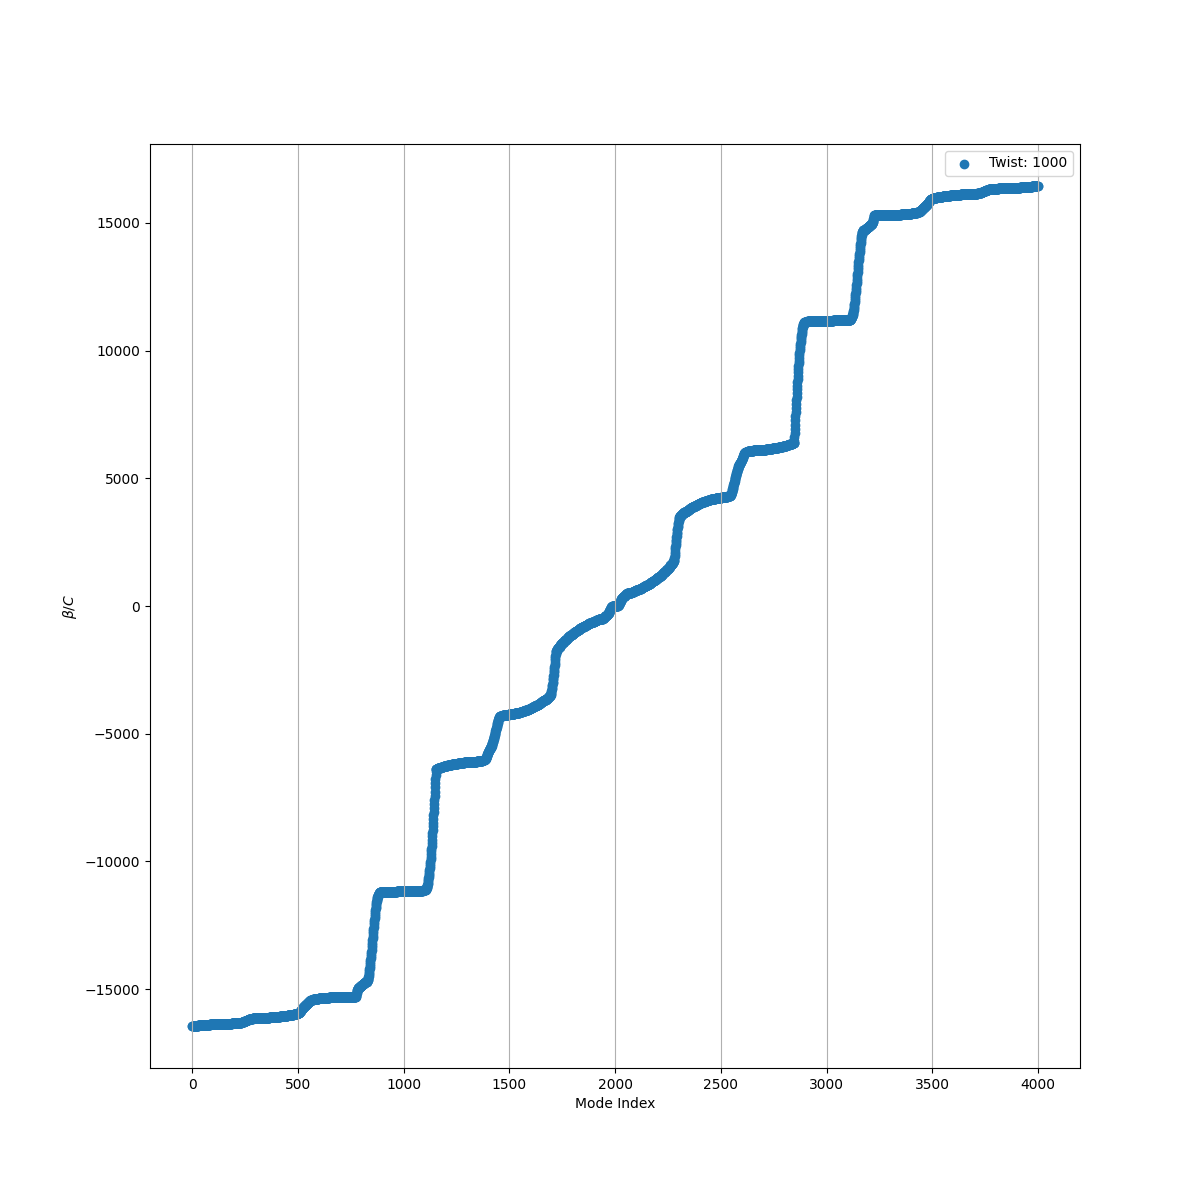

In [27]:
# Finding propagation constants of the twisted system while neglecting the onsite terms
beta_vals_1, beta_vecs_1 = find_eigvalues(b_10_list, 4.2, 6700, 5876619.5, 5000, with_onsite=False)
plot_betas(beta_vals_1, 'Twist: 1000')

False
(-0.9917154819639897+1.7070162415155493e-18j)


(-0.9917154819639897+1.7070162415155493e-18j)

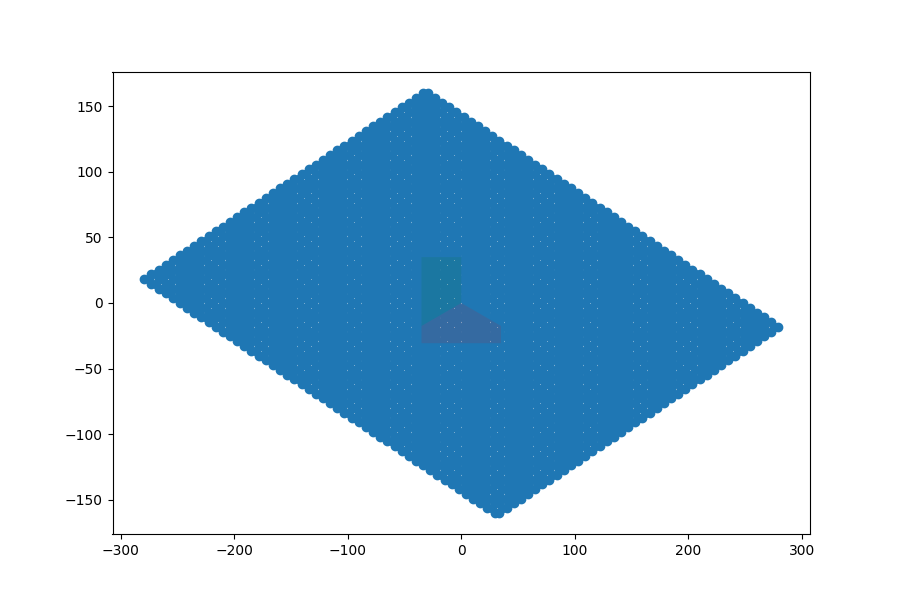

In [28]:
# calculating chern number over selected band 
real_space_chern_calc(beta_vals_1, beta_vecs_1, 3226, 35)